In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np

import time
import random
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands
import pandas as pd


import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
N_SIMULATION = 5000
SCENARIO = 'factory'

data_path = parentdir + '/data/ns3/' + SCENARIO
path_received = data_path + '/raw/received_packets.txt'
path_transmitted = data_path + '/raw/transmitted_packets.txt'

serialNumber = []
TimeStampReceived = []
TimeStampTransmitted = []
TimeDiff = []

dataReceived = pd.read_csv(path_received, delimiter=":", header=None, names=["serial", "timeStamp"])
serialReceived   = dataReceived['serial'].values
timeStampReceived = dataReceived['timeStamp'].values

dataTransmitted = pd.read_csv(path_transmitted,delimiter=":", header=None, names=["serial", "timeStamp"])
serialTransmitted   = dataTransmitted['serial'].values
timeStampTransmitted = dataTransmitted['timeStamp'].values

In [4]:
N = dataReceived['serial'].size

for i in range(1, N):

    received = dataReceived[dataReceived['serial'] == serialTransmitted[i]]
    if (not received.empty) and received['timeStamp'].values[0] != 0 and timeStampTransmitted[i] != 0 :
        timediff = received['timeStamp'].values[0] - timeStampTransmitted[i]
    else:
        timediff = np.inf
    TimeDiff.append(timediff)
    
rtt = 2e-3 * np.array(TimeDiff)

In [5]:
total_length = rtt.shape[0]

In [18]:
N_SIMULATION = 5000
num_traj = 100
delays_all = []
for k in range(num_traj):
    start = random.randint(0, total_length - N_SIMULATION)
    td = rtt[start: start + N_SIMULATION]
    time_received = np.array([i + td[i] for i in range(N_SIMULATION)])
    delays = np.zeros(N_SIMULATION)
    delayed_ids = N_SIMULATION * [0]
    for i in range(N_SIMULATION):
        # find the latest command arrived before the current time
        id_arrived = np.nonzero(time_received <= i)[0]
        if id_arrived.size > 0:
            delayed_id = id_arrived.max()
        else:
            delayed_id = 0
        delays[i] = i - delayed_id
        delayed_ids[i] = int(delayed_id)
    delays_all.append(delays)
    np.save(data_path + '/delayed_ids/'+ str(k), delayed_ids)
delays_all = np.concatenate(delays_all)

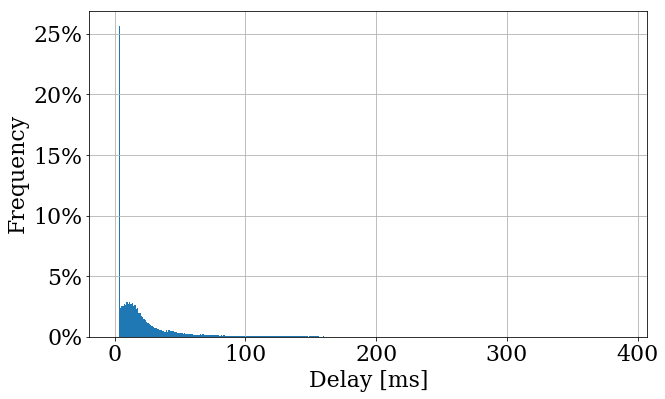

In [19]:
hist, bin_edges = np.histogram(delays_all, bins=np.arange(0, 100, 10))
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.hist(delays_all, 
        bins=np.arange(0, np.nanmax(delays_all[delays_all != np.inf])), 
        weights=np.ones(len(delays_all)) / len(delays_all))

ax.grid()
ax.set_xlabel('Delay [ms]')
ax.set_ylabel('Frequency' )
_ = ax.set_yticklabels(['%1.0f%%' %i for i in 100*ax.get_yticks()])

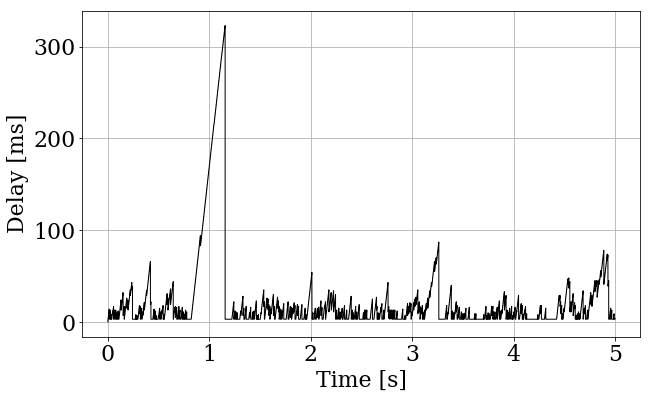

In [22]:
dt = 0.001
T = np.arange(0, N_SIMULATION*dt, dt)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(T, delays, lw=1, c='k', ls='-', drawstyle='steps')

ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Delay [ms]' )
ax.ticklabel_format(style='sci',scilimits=(-3,4), axis='y')
# ax.set_ylim([0, 150])
fig.savefig('factory.png')